In [362]:
import scipy.signal, scipy.io, os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
%matplotlib inline

Helper functions

In [383]:
def plotDataSection(data, title, 
    startTime=0, 
    endTime=None, 
    sampleRate=24e3,
    idxPeakMarker=np.array([]),
    ax=None,
    ):
    '''
    plot data in a certain interval.
    input:
    - data: [idx of channels, idx of datapoints]
    '''
    if data.ndim == 1:
        data = data.reshape(1, -1)
    if endTime is None:
        endTime = data.shape[-1]/sampleRate
        sectionLength = data.shape[-1]
        dataSection = data
    else:
        idxStart = int(startTime*sampleRate)
        idxEnd = int(endTime*sampleRate)
        sectionLength = idxEnd - idxStart
        dataSection = data[:, idxStart: idxEnd]
    time = np.linspace(startTime, endTime, num=sectionLength)
    if ax == None:
        fig, ax = plt.subplots()
    for idxCh, chData in enumerate(dataSection):
        ax.plot(time, chData, label=f'Ch {idxCh}')
        if idxPeakMarker.any():
            ax.plot(time[idxPeakMarker], chData[idxPeakMarker], '*')
    ax.set_title(title)
    ax.set_xlim([startTime, endTime])
    ax.set_xlabel('time [s]')
    ax.set_ylabel('voltage [uv]')
    ax.grid(True)
    ax.legend()
    return fig, ax

def plotSectionMeanAndSTD(data, title, sampleRate=24e3):
    dataMean = data.mean(axis=0)
    time = np.linspace(0, len(dataMean)/sampleRate, num=len(dataMean))
    dataSTD = data.std(axis=0)
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(211)
    ax1.plot(time, dataMean, color='b')
    ax1.plot(time, dataMean + dataSTD, 'r.')
    ax1.plot(time, dataMean - dataSTD, 'r.')
    ax1.set_title(title)
    ax1.set_xlabel('time [s]')
    ax1.set_ylabel('voltage [uv]')
    ax1.grid(True)
    ax2 = fig.add_subplot(212)
    ax2.plot(time, dataSTD)
    ax2.set_xlabel('time [s]')
    ax2.set_ylabel('STD')
    ax2.grid(True)

def getPeakSections(data, idxPeaks, windowSizeBefore, windowSizeAfter):
    peakSections = []
    for i in idxPeaks:
        peakSections.append(data[i - windowSizeBefore: i + windowSizeAfter])
    return np.array(peakSections)

def removeOutOfBoundIdx(idx, lowBound, upBound):
    '''Remove the idx that are too close to the begining or end 
    defined by lowBound and upBound.
    Needed to avoid index out of bound error when cutting data into small sections.
    '''
    return idx[np.logical_and(idx > lowBound, idx < upBound)]

def plotPSD(data, sampleRate, title):
    freq, PSD = scipy.signal.welch(data, sampleRate, window=scipy.signal.windows.hann(512))
    fig, ax = plt.subplots()
    ax.plot(freq, PSD.transpose())
    ax.set_xlim([0, 150])
    ax.set_yscale('log')
    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('PSD')
    ax.set_title(title)
    ax.grid(True)
    return fig, ax

In [364]:
from matplotlib.widgets import Slider

def plotWithWidget(data, sampleRate, plotWindowSize):
    '''
    data need to have shape [idx channel, idx sample] 
    '''
    %matplotlib widget
    def update(startTime):
        global startIdx, endIdx
        startIdx = int(startTime*sampleRate)
        endIdx = int((startTime + plotWindowSize)*sampleRate)        
        newData = data[:, startIdx: endIdx]
        for idxCh, curve in enumerate(curves):
            curve.set_xdata(time[startIdx: endIdx])
            curve.set_ydata(newData[idxCh, :].transpose())
        ax.set_xlim([startTime, startTime + plotWindowSize])
        # ax.set_ylim([newData.min()*0.8, newData.max()*1.2])
        fig.canvas.draw_idle()
    
    def changeTime(val):
        global startTime
        startTime = timeSlider.val
        update(startTime)

    # plotWindowSize = 10 # [seconds]
    dataSize = data.shape[-1]
    recDuration = dataSize/sampleRate

    startIdx = 0
    endIdx = int(plotWindowSize*sampleRate)
    startTime = 0

    time = np.linspace(0, recDuration, num=dataSize)
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.subplots_adjust(bottom=0.25)
    curves = ax.plot(
        time[startIdx: endIdx], 
        data[:, startIdx: endIdx].transpose(),
        )
    ax.set_xlim([startTime, startTime + plotWindowSize])
    # update(startTime)
    ax.grid(True)
    ax.set_xlabel('time [s]')
    ax.set_ylabel('voltage [mv]')

    # ax.legend()

    timeSlider = Slider(
        (
            plt.axes([0.2, 0.1, 0.65, 0.03], facecolor = 'White')
        ),
        label='Time', 
        valmin = 0.0, 
        valmax = recDuration
    )

    timeSlider.on_changed(changeTime)

    plt.show()

Load data

In [365]:
sampleRate = 300
dataFolder = 'Synthetic_Data'
fileList = os.listdir(dataFolder)
dataset = []
for file in fileList:
    data = scipy.io.loadmat(dataFolder + '/' + file)
    dataset.append(data['val'].squeeze())

`dataset[idx of trail][idx of channel, idx of sample]`

In [366]:
idxTrial = 19
data = dataset[idxTrial]

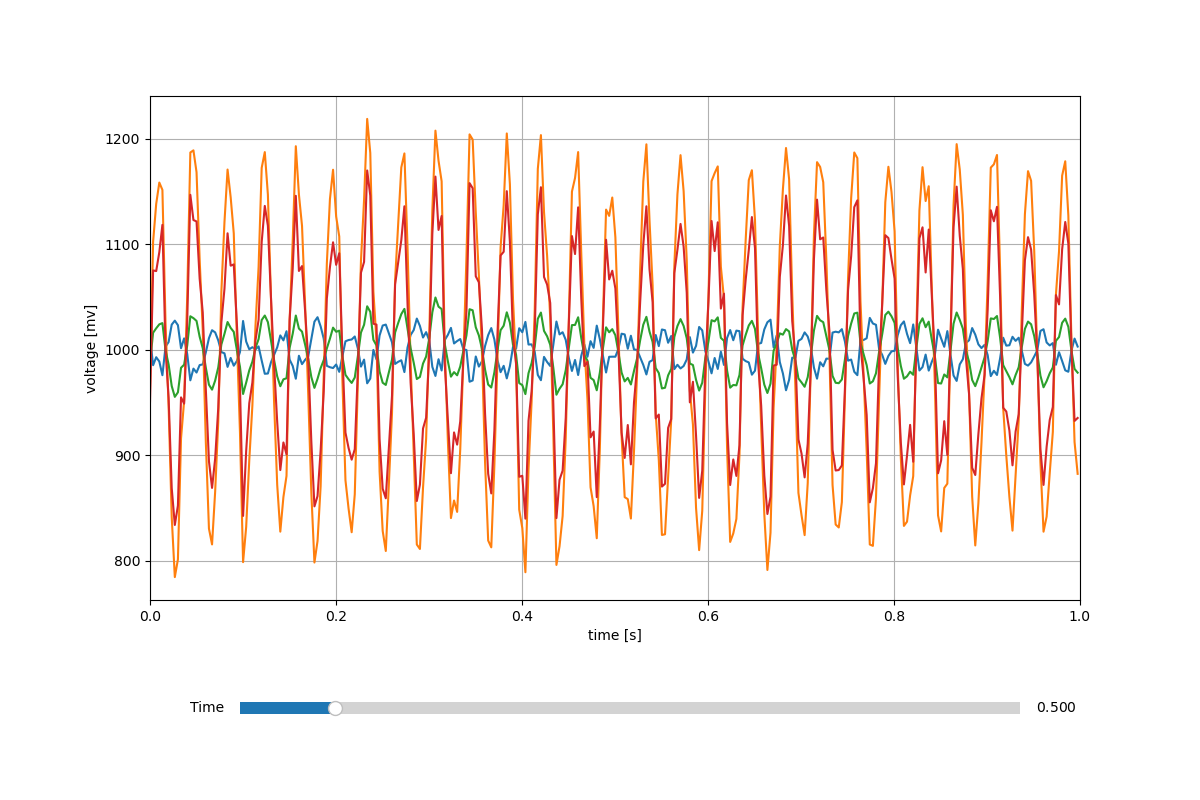

In [367]:
plotWithWidget(data, sampleRate, 1)

In [368]:
plt.close()
%matplotlib inline

Check spectrum

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'Unfiltered PSD'}, xlabel='frequency [Hz]', ylabel='PSD'>)

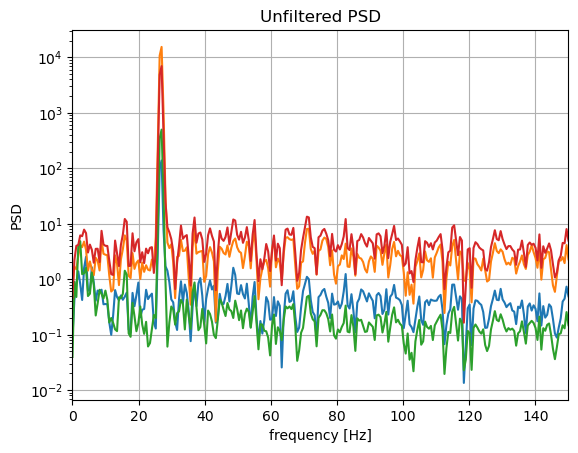

In [369]:
plotPSD(data, sampleRate, 'Unfiltered PSD')

In [370]:
# windowSize = int(0.06*sampleRate) + 1
# medfiltData = scipy.signal.medfilt(dataset[idxTrail], (1, windowSize))
# plotPSD(medfiltData, sampleRate, 'PSD after median filtering')

The median filter did not make too much difference.

Next try to remove the PSD spike around 20Hz.

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'data after high pass'}, xlabel='time [s]', ylabel='voltage [uv]'>)

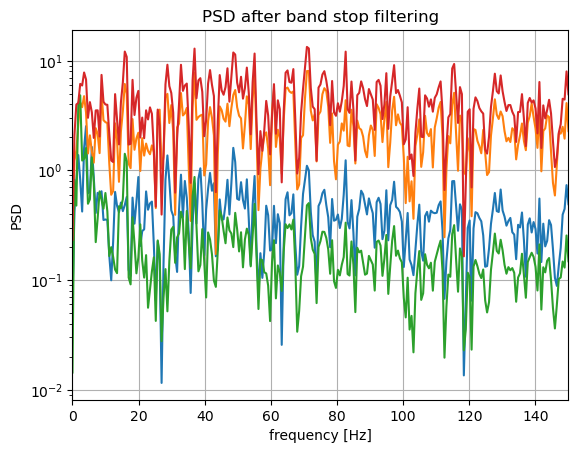

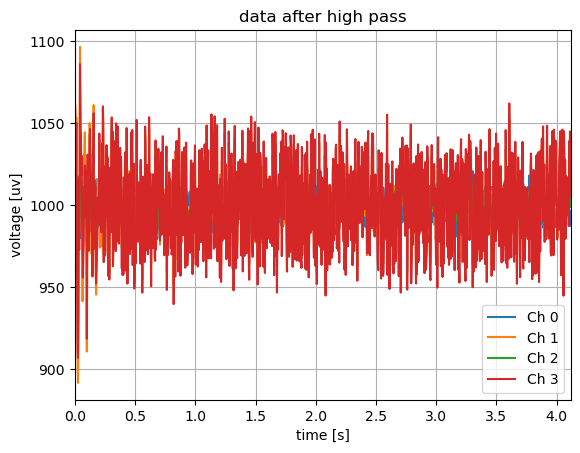

In [371]:
bandpassWidth = 1.5
freq, PSD = scipy.signal.welch(data, sampleRate, window=scipy.signal.windows.hann(512))
spikeFreq = freq[np.argmax(np.sum(PSD, axis=0))]
bandstopSOS = scipy.signal.butter(2, (spikeFreq - bandpassWidth/2, spikeFreq + bandpassWidth/2), 'bandstop', fs=sampleRate, output='sos')
bandstopfiltData = scipy.signal.sosfiltfilt(bandstopSOS, data, axis=1)
plotPSD(bandstopfiltData, sampleRate, 'PSD after band stop filtering')
plotDataSection(bandstopfiltData, 'data after high pass', sampleRate=sampleRate)

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'data after high pass'}, xlabel='time [s]', ylabel='voltage [uv]'>)

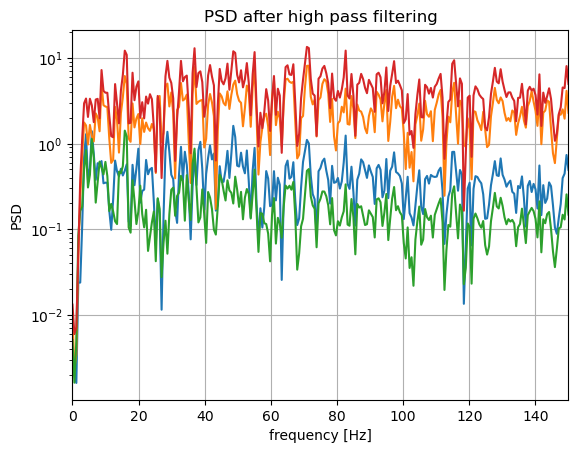

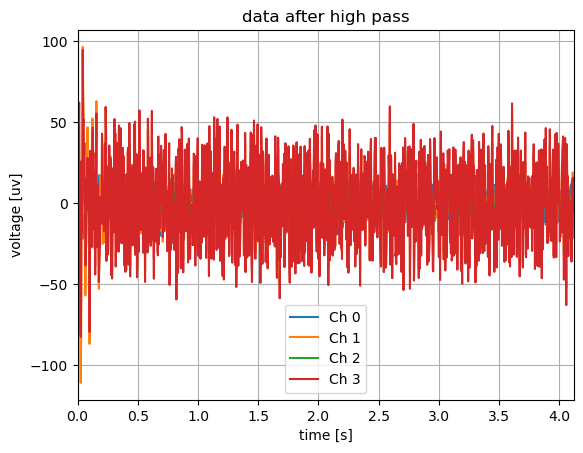

In [372]:
highpassSOS = scipy.signal.butter(2, 3.17, 'highpass', fs=sampleRate, output='sos')
highpassfiltData = scipy.signal.sosfiltfilt(highpassSOS, bandstopfiltData, axis=1)
plotPSD(highpassfiltData, sampleRate, 'PSD after high pass filtering')
plotDataSection(highpassfiltData, 'data after high pass', sampleRate=sampleRate)

In [373]:
# plotWithWidget(bandstopfiltData, sampleRate, 2)

In [374]:
# plt.close()
# %matplotlib inline

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'data after low pass'}, xlabel='time [s]', ylabel='voltage [uv]'>)

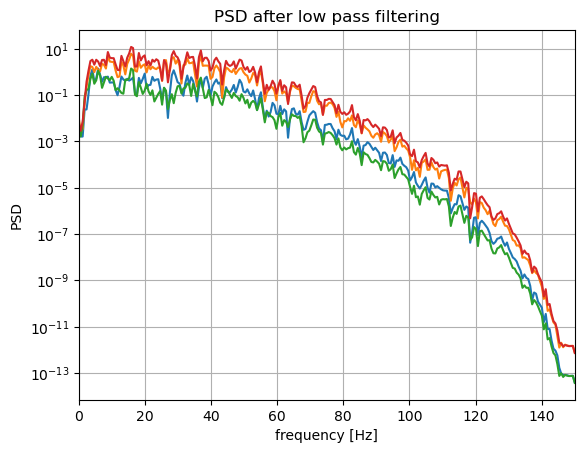

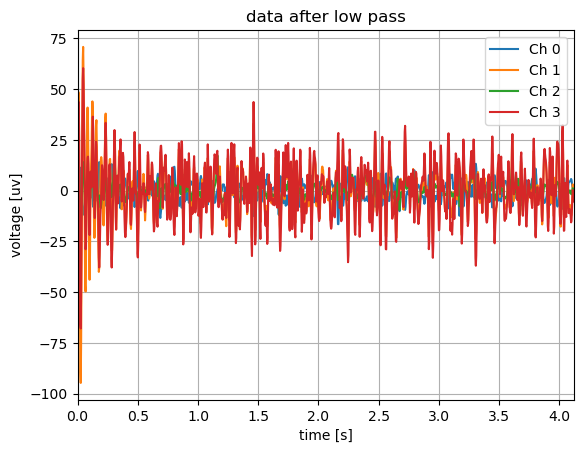

In [375]:
lowpassSOS = scipy.signal.butter(2, 50, 'lowpass', fs=sampleRate, output='sos')
lowpassfiltData = scipy.signal.sosfiltfilt(lowpassSOS, highpassfiltData, axis=1)
plotPSD(lowpassfiltData, sampleRate, 'PSD after low pass filtering')
plotDataSection(lowpassfiltData, 'data after low pass', sampleRate=sampleRate)

Apply a Tukey window to the filtered data in order to remove artifacts at the beginning and end of the signals.

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'data after Tukey window'}, xlabel='time [s]', ylabel='voltage [uv]'>)

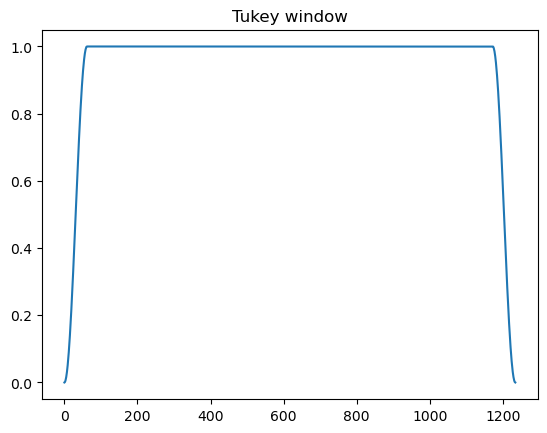

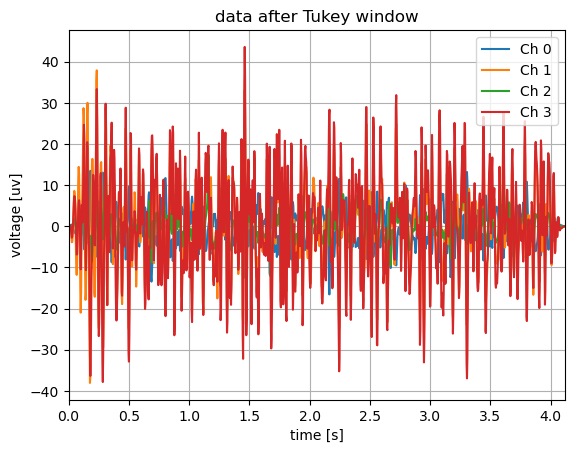

In [376]:
tWin = scipy.signal.windows.tukey(data.shape[-1], alpha = 0.1)
_, ax = plt.subplots()
ax.plot(tWin)
ax.set_title('Tukey window')

processedData = lowpassfiltData*tWin
plotDataSection(processedData, 'data after Tukey window', sampleRate=sampleRate)

In [377]:
# plotWithWidget(lowpassfiltData, sampleRate, 2)

In [378]:
# plt.close()
# %matplotlib inline

In [379]:
from sklearn.decomposition import FastICA
transform = FastICA(n_components=4, whiten='unit-variance')
# ICAData = transform.fit_transform(lowpassfiltData.T).T
ICAData = transform.fit_transform(processedData.T).T

c:\Users\101ra\miniconda3\envs\rub\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'ICA'}, xlabel='time [s]', ylabel='voltage [uv]'>)

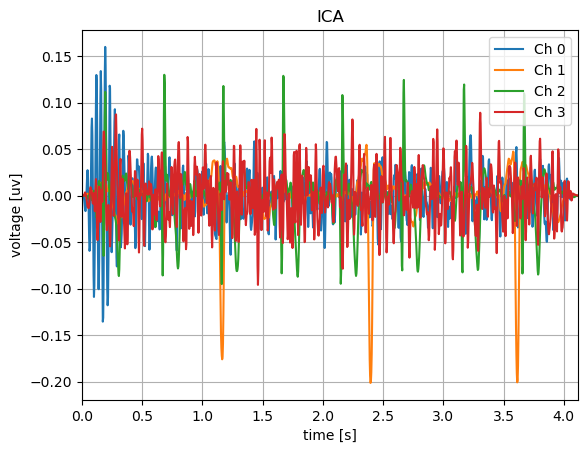

In [380]:
plotDataSection(ICAData, 'ICA', sampleRate=sampleRate)

height threshold: 0.0869439161029229
Error! 3 valid channels found.


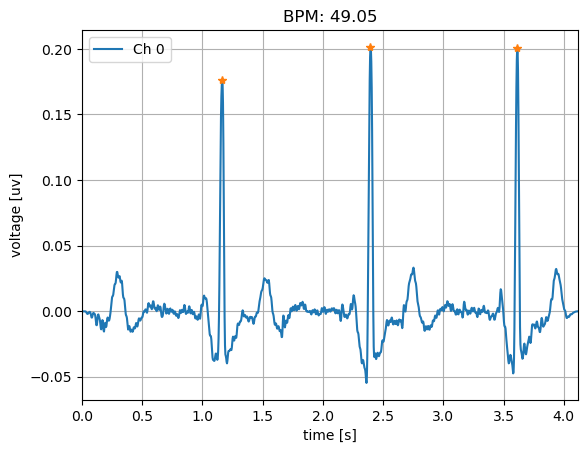

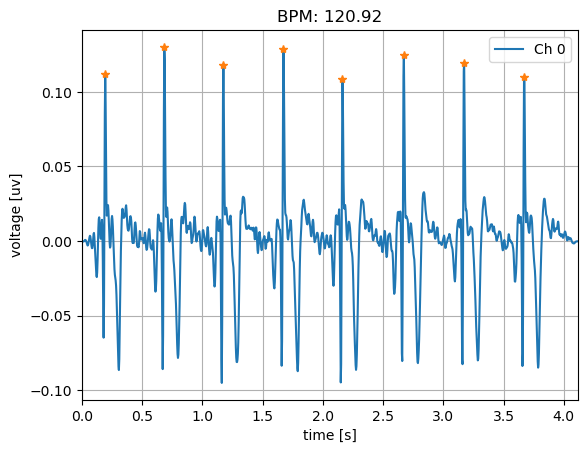

In [381]:
maxBPM = 250
minBPM = 30

def getValidCh(ICAData, sampleRate, maxBPM, minBPM):
    distanceThreshold = sampleRate*60/maxBPM
    heightThreshold = np.percentile(np.abs(ICAData).flatten(), 99)*0.8
    print(f'height threshold: {heightThreshold}')

    dataset = {}
    dataset['BPM'] = []
    dataset['intervalSTD'] = []
    dataset['data'] = []
    dataset['idxPeaks'] = []
    for chData in ICAData:
        idxPeaks, peakProperties = scipy.signal.find_peaks(
            np.abs(chData), height=heightThreshold, distance=distanceThreshold)
        # minimum number of spikes for the duration of the signal
        minSpikeCount = chData.shape[-1]/sampleRate/60*minBPM 
        if idxPeaks.size > minSpikeCount:
            interval = (idxPeaks[1:] - idxPeaks[:-1])/sampleRate # [seconds]
            intervalSTD = np.std(interval)
            avgInterval = interval.mean() # [seconds]
            avgBPM = 1/avgInterval*60
            if avgBPM > minBPM and avgBPM < maxBPM:
                if chData[idxPeaks].mean() < 0:
                    chData = -chData
                dataset['BPM'].append(avgBPM)
                dataset['intervalSTD'].append(intervalSTD)
                dataset['data'].append(chData)
                dataset['idxPeaks'].append(idxPeaks)

    numValid = len(dataset['BPM'])
    if numValid != 2:
        Error = True
        print(f'Error! {numValid} valid channels found.')
    else:
        Error = False
    result = dataset
    return Error, result

def plotDataset(dataset, sampleRate):
    for idxCh in range(2):
        BPM = dataset['BPM'][idxCh]
        chData = dataset['data'][idxCh]
        idxPeaks = dataset['idxPeaks'][idxCh]
        fig, ax = plotDataSection(chData, f'BPM: {BPM:.2f}', 
            sampleRate=sampleRate, idxPeakMarker=idxPeaks)

Error, result = getValidCh(ICAData, sampleRate, maxBPM=maxBPM, minBPM=minBPM)
plotDataset(result, sampleRate)